In [ ]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
!pip install pytorch_lightning >/dev/null
import pytorch_lightning as pl

In [ ]:
!git lfs install
!git clone https://huggingface.co/datasets/LinYyou/TP_Transformers_data
#!tar -xzf /content/TP_Transformers_data/math_data_1k.tar.gz >/dev/null
#!tar -xzf /content/TP_Transformers_data/math_data_10k.tar.gz >/dev/null
!tar -xzf /content/TP_Transformers_data/math_data_100k.tar.gz >/dev/null
#!tar -xzf /content/TP_Transformers_data/math_data_1M.tar.gz >/dev/null

Git LFS initialized.
Cloning into 'TP_Transformers_data'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 34 (delta 11), reused 0 (delta 0), pack-reused 3
Unpacking objects: 100% (34/34), 4.33 KiB | 739.00 KiB/s, done.
Filtering content: 100% (7/7), 3.38 GiB | 131.74 MiB/s, done.


In [ ]:
from torchtext.vocab import build_vocab_from_iterator

chars = "˽$§what isprobfequnclkdm?0{g:3,17}.v/4x5298zy6j-*+=()'><!"

# Generator function to build the vocab
def yield_tokens(chars):
  for char in chars:
    yield char

vocab = build_vocab_from_iterator(yield_tokens(chars))

print(f'Vocab size: {len(vocab)}')
print(f'Vocab chars: {vocab.get_itos()}')

Vocab size: 57
Vocab chars: [' ', '!', '$', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '<', '=', '>', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '}', '§', '˽']


In [ ]:
import os
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

class MathDataset(Dataset):
    """
    Args:
      partition = [train, val, interpolate, extrapolate]
      tasks = list of indexes or names of tasks in tasks_interpolate or tasks_extrapolate
    """
    def __init__(self, path: str, vocab, partition: str, task=None, src_max_len=160, trg_max_len=30, verbose=True):
        self.path = path
        self.src = []
        self.trg = []
        self.src_max_len = src_max_len
        self.trg_max_len = trg_max_len
        self.pad =  '˽'
        self.prefix = '$'
        self.suffix = '§'
        self.vocab = vocab
        self.verbose = verbose

        print(f'Loading {partition} data...')
        self._load_data(partition, task)

    def _load_data(self, partition: str, task=None):
        """
        Load the selected partition into self.src and self.trg

        Args:
          partition: one among [train, val, interpolate, extrapolate]
          task: index or name of one among tasks_interpolate if partition=interpolate
                  or among tasks_extrapolate if partition=extrapolate
        """
        if partition == 'train':
            data_path = os.path.join(self.path, 'trainset.csv')

        elif partition == 'val':
            data_path = os.path.join(self.path, 'valset.csv')

        elif partition == 'interpolate':
            if isinstance(task, (int)):
                data_path = os.path.join(self.path, 'interpolate', f'{self.tasks_interpolate[task]}.csv')
            else:
                data_path = os.path.join(self.path, 'interpolate', f'{task}.csv')
        elif partition =='extrapolate':
            if isinstance(task, (int)):
                data_path = os.path.join(self.path, 'extrapolate', f'{self.tasks_extrapolate[task]}.csv')
            else:
                data_path = os.path.join(self.path, 'extrapolate', f'{task}.csv')
        else:
            raise Exception('Choose a partition among [train, val, interpolate, extrapolate]')

        with open(data_path, 'r') as file:
            lines = file.readlines()
            for line in tqdm(lines, disable=(not self.verbose)):
                sample = line.split('\t')
                self.src.append(sample[0])
                self.trg.append(sample[1])

    def __len__(self):
        return len(self.src)

    def __getitem__(self, index):
        return self.src[index], self.trg[index]

In [ ]:
def collate_function(batch):
    src_batch = None
    trg_batch = None
    src_max_len = 160
    trg_max_len = 30
    new_batch = []
    for src, trg in batch:
        src_id = torch.tensor([vocab['$']] + [vocab[c.lower()] for c in src.strip()] + [vocab['§']])
        src_id = F.pad(src_id, (0, src_max_len - len(src_id)), value=vocab['˽']).unsqueeze(0)
        if src_batch == None:
            src_batch = src_id
        else:
            src_batch = torch.cat((src_batch, src_id), 0)

        trg_id = torch.tensor([vocab['$']] + [vocab[c.lower()] for c in trg.strip()] + [vocab['§']])
        trg_id = F.pad(trg_id, (0, trg_max_len - len(trg_id)), value=vocab['˽']).unsqueeze(0)
        if trg_batch == None:
            trg_batch = trg_id
        else:
            trg_batch = torch.cat((trg_batch, trg_id), 0)

    return src_batch, trg_batch

In [ ]:
path = '/content/content/data2export'
training_set = MathDataset(path, vocab, 'train')
validation_set = MathDataset(path, vocab, 'val')
BATCH_SIZE = 256

train_loader = DataLoader(training_set,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers = 8,
                          collate_fn = collate_function)
val_loader = DataLoader(validation_set,
                        batch_size=BATCH_SIZE,
                        num_workers = 8,
                        collate_fn = collate_function)


Loading train data...


  0%|          | 0/5039816 [00:00<?, ?it/s]

Loading val data...


  0%|          | 0/559993 [00:00<?, ?it/s]

In [ ]:
def get_default_device():
    """Picking GPU if available or else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_default_device()
print(device)

cuda


In [ ]:
import numpy as np

""" V2 """
class FeedForwardBlock(nn.Module):
    def __init__(self, embedding_dim: int, hidden_dim: int, dropout: float) -> None:
        super().__init__()
        self.linear_1 = nn.Linear(embedding_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(hidden_dim, embedding_dim)

    def forward(self, x):
        # (batch_size, seq_len, embedding_dim) --> (batch_size, seq_len, hidden_dim) --> (batch_size, seq_len, embedding_dim)
        x = self.linear_1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        return self.linear_2(x)

class ResidualConnectionBlock(nn.Module):
    def __init__(self, embedding_dim: int, dropout: float) -> None:
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(embedding_dim)

    def forward(self, input, layer):
        # Layer norm + layer + dropout + residual connection
        x = self.norm(input)
        x = layer(x)
        x = self.dropout(x)
        return input + x

class InputEmbedding(nn.Module):
    def __init__(self, embedding_dim: int, vocab_size: int) -> None:
        super().__init__()
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

    def convert_back(self, trg):
        return torch.matmul(trg, torch.transpose(self.embedding.weight, 0, 1))

    def forward(self, x):
        # (batch_size, seq_len) --> (batch_size, seq_len, embedding_dim)
        # Multiply by sqrt(embedding_dim) to scale the embeddings according to the original transformer paper
        scale = math.sqrt(self.embedding_dim)
        return self.embedding(x) * scale

class PositionalEncoding(nn.Module):
    """
    Classic positional encoding (sinusoidal) + relational vector
    """
    def __init__(self, embedding_dim: int=512, seq_len: int=500, dropout: float=0.0) -> None:
        super().__init__()
        self.linear = nn.Linear(embedding_dim, embedding_dim)
        self.dropout = nn.Dropout(dropout)
        # Create a matrix of shape (seq_len, embedding_dim)
        pe = torch.zeros(seq_len, embedding_dim)
        # Create a vector of shape (seq_len)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1) # (seq_len, 1)
        # Create a vector of shape (embedding_dim)
        div_term = torch.exp(torch.arange(0, embedding_dim, 2).float() * (-math.log(10000.0) / embedding_dim)) # (embedding_dim / 2)
        # Apply sine to even indices
        pe[:, 0::2] = torch.sin(position * div_term) # sin(position * (10000 ** (2i / embedding_dim))
        # Apply cosine to odd indices
        pe[:, 1::2] = torch.cos(position * div_term) # cos(position * (10000 ** (2i / embedding_dim))
        # Add a batch dimension to the positional encoding
        pe = pe.unsqueeze(0) # (1, seq_len, embedding_dim)
        # Register the positional encoding as a buffer
        self.register_buffer('pe', pe)

    def forward(self, x):
        # Sum up the embedding and the positional encoding
        x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False) # (batch_size, seq_len, embedding_dim)
        # Create the relational vector to initialize the embedding into ~N(1, 1)
        r = self.linear(x) + 1.0 # (batch_size, seq_length, embedding_dim)
        # Tensor product between relational vector and the embedding and apply dropout
        return self.dropout(x * r)
        #return self.dropout(x)


class TPMultiHeadAttentionBlock(nn.Module):
    def __init__(self, embedding_dim: int, num_heads: int, dropout: float) -> None:
        super().__init__()
        self.embedding_dim = embedding_dim # Embedding vector size
        self.num_heads = num_heads # Number of heads
        self.attention_scores = None
        # Make sure embedding_dim is divisible by num_heads
        assert embedding_dim % num_heads == 0, "embedding_dim is not divisible by num_heads"

        self.head_dim = embedding_dim // num_heads

        self.w_q = nn.Linear(embedding_dim, embedding_dim) # Wq
        self.w_k = nn.Linear(embedding_dim, embedding_dim) # Wk
        self.w_v = nn.Linear(embedding_dim, embedding_dim) # Wv
        self.w_r = nn.Linear(embedding_dim, embedding_dim) # Wr
        self.w_o = nn.Linear(embedding_dim, embedding_dim) # Wo

        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)

        # Initialize weights
        #self.init_weights()

    def init_weights(self):
        nn.init.xavier_uniform_(self.w_q.weight)
        nn.init.xavier_uniform_(self.w_k.weight)
        nn.init.xavier_uniform_(self.w_v.weight)
        nn.init.xavier_uniform_(self.w_o.weight)
        nn.init.xavier_normal_(self.w_r.weight)

    def attention(self, query, key, value, mask, dropout: nn.Dropout):

        attention_scores = (query @ key.transpose(-2, -1)) / math.sqrt(self.head_dim) # (batch_size, num_heads, seq_len, head_dim) --> (batch_size, num_heads, seq_len, seq_len)

        """
        if mask is not None:
            # Give a very low attention value to the positions where mask == 0
            attention_scores = attention_scores.masked_fill_(mask == 0, -np.inf)
        """
        # Apply mask
        attention_scores = attention_scores.masked_fill_(mask == 0, -1e12)

        # Apply softmax
        attention_scores = self.softmax(attention_scores) # (batch_size, num_heads, seq_len, seq_len)

        # Apply dropout
        if dropout is not None:
            attention_scores = dropout(attention_scores)

        # Return also attention scores which can be used for visualization
        return (attention_scores @ value), attention_scores # (batch_size, num_heads, seq_len, seq_len) --> (batch_size, num_heads, seq_len, head_dim)

    def forward(self, q, k, v, mask):

        batch_size = q.shape[0]

        # (batch_size, seq_len, embedding_dim) --> (batch_size, seq_len, embedding_dim)
        key   = self.w_k(k)
        value = self.w_v(v)
        query = self.w_q(q)
        role  = self.w_r(q)

        # (batch_size, seq_len, embedding_dim) --> (batch_size, seq_len, num_heads, head_dim) --> (batch_size, num_heads, seq_len, head_dim)
        query = query.view(batch_size, query.shape[1], self.num_heads, self.head_dim).transpose(1, 2)
        key   = key.view(batch_size, key.shape[1], self.num_heads, self.head_dim).transpose(1, 2)
        value = value.view(batch_size, value.shape[1], self.num_heads, self.head_dim).transpose(1, 2)
        role  = role.view(batch_size, role.shape[1], self.num_heads, self.head_dim).transpose(1, 2)

        # Calculate attention
        x, self.attention_scores = self.attention(query, key, value, mask, self.dropout)

        # Apply role
        x = x * role

        # Store the heads into contiguous memory in order to reshape with .view()
        x = x.transpose(1, 2).contiguous() # (batch_size, num_heads, seq_len, head_dim) --> (batch_size, seq_len, num_heads, head_dim)

        # Combine all the heads together
        x = x.view(x.shape[0], -1, self.embedding_dim) # (batch_size, seq_len, num_heads, head_dim) --> (batch, seq_len, embedding_dim)

        # Multiply by Wo
        return self.w_o(x) # (batch_size, seq_len, embedding_dim) --> (batch_size, seq_len, embedding_dim)

class EncoderBlock(nn.Module):
    def __init__(self, embedding_dim: int, ffn_dim: int, num_heads: int, dropout: float) -> None:
        super().__init__()
        self.self_attention = TPMultiHeadAttentionBlock(embedding_dim, num_heads, dropout)
        self.ffn = FeedForwardBlock(embedding_dim, ffn_dim, dropout)
        self.res1 = ResidualConnectionBlock(embedding_dim, dropout)
        self.res2 = ResidualConnectionBlock(embedding_dim, dropout)
        self.norm = nn.LayerNorm(embedding_dim)

    def forward(self, src, src_mask):
        src = self.res1(src, lambda x: self.self_attention(x, x, x, src_mask)) # we basically want to pass a function that takes only src as input, we couldn't pass the attention layer directly since it required multiple arguments
        src = self.res2(src, self.ffn)
        return self.norm(src)

class Encoder(nn.Module):
    def __init__(self, embedding_dim: int, ffn_dim: int, num_heads: int=4, num_layers: int=2, dropout: float=0.4) -> None:
        super().__init__()
        self.layers = nn.ModuleList([EncoderBlock(embedding_dim, ffn_dim, num_heads, dropout) for _ in range(num_layers)])

    def forward(self, src, src_mask):
        for layer in self.layers:
            src = layer(src, src_mask)
        return src

class DecoderBlock(nn.Module):
    def __init__(self, embedding_dim: int, ffn_dim: int, num_heads: int, dropout: float) -> None:
        super().__init__()
        self.self_attention = TPMultiHeadAttentionBlock(embedding_dim, num_heads, dropout)
        self.cross_attention = TPMultiHeadAttentionBlock(embedding_dim, num_heads, dropout)
        self.ffn = FeedForwardBlock(embedding_dim, ffn_dim, dropout)
        self.res1 = ResidualConnectionBlock(embedding_dim, dropout)
        self.res2 = ResidualConnectionBlock(embedding_dim, dropout)
        self.res3 = ResidualConnectionBlock(embedding_dim, dropout)
        self.norm = nn.LayerNorm(embedding_dim)

    def forward(self, src, trg, src_mask, trg_mask):
        trg = self.res1(trg, lambda x: self.self_attention(x, x, x, trg_mask))
        trg = self.res2(trg, lambda x: self.cross_attention(x, src, src, src_mask))
        trg = self.res3(trg, self.ffn)
        return self.norm(trg)

class Decoder(nn.Module):
    def __init__(self, embedding_dim: int, ffn_dim: int, num_heads: int=4, num_layers: int=2, dropout: float=0.4) -> None:
        super().__init__()
        self.layers = nn.ModuleList([DecoderBlock(embedding_dim, ffn_dim, num_heads, dropout) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(embedding_dim)

    def forward(self, src, trg, src_mask, trg_mask):
        for layer in self.layers:
            trg = layer(src, trg, src_mask, trg_mask)
        return trg

class TPTransformer(nn.Module):
    def __init__(self, vocab_size: int, max_output_length: int=30, embedding_dim: int=128, num_heads: int=8, num_layers: int=6, ffn_dim: int=512, dropout: float=0) -> None:
        super().__init__()

        # Parameters
        self.max_output_length = max_output_length
        self.embedding_dim = embedding_dim
        self.num_layers = num_layers
        self.pad_index = vocab['˽']
        self.sos_index = vocab['$']
        self.eos_index = vocab['§']

        # Embedding
        self.embedding = InputEmbedding(embedding_dim, vocab_size)
        self.pos_encoder = PositionalEncoding(embedding_dim)

        # Encoder
        self.encoder = Encoder(embedding_dim, ffn_dim, num_heads, num_layers, dropout)

        # Decoder
        self.decoder = Decoder(embedding_dim, ffn_dim, num_heads, num_layers, dropout)
        self.fc = nn.Linear(embedding_dim, vocab_size)

        # It is empirically significant to initialize weights properly
        self.init_weights()

    def init_weights(self):
        """
        Normalize the initial weights setting the mean to 0 and the std to 1 / sqrt(embedding_dim)
        """
        nn.init.xavier_normal_(self.embedding.embedding.weight)
        nn.init.xavier_normal_(self.pos_encoder.linear.weight)
        nn.init.xavier_normal_(self.fc.weight)

    def forward(self, src: torch.Tensor, trg: torch.Tensor) -> torch.Tensor:
        """
        Input
            src: (batch_size, src_seq_length) with elements in (0, vocab_size)
            trg: (batch_size, trg_seq_length) with elements in (0, vocab_size)
        Output
            logits: (batch_size, vocab_size, trg_seq_length)
        """
        # Create the masks
        src_mask = self.make_src_mask(src) # (batch_size, src_seq_length, embedding_dim)
        trg_mask = self.make_trg_mask(trg) # (batch_size, trg_seq_length, embedding_dim)

        # Encode + decode
        encoded_src = self.encode(src, src_mask)  # (batch_size, src_seq_length, embedding_dim)
        out = self.decode(encoded_src, trg, src_mask, trg_mask)  # (batch_size, trg_seq_length, vocab_size)
        #return out
        return self.embedding.convert_back(out) # (batch_size, trg_seq_length, vocab_size)

    def encode(self, src: torch.Tensor, src_mask: torch.Tensor=None) -> torch.Tensor:
        """
        Input
            src: (batch_size, src_seq_length) with elements in (0, vocab_size)
        Output
            embedding: (batch_size, src_seq_length, embedding_dim)
        """
        src = self.embedding(src)  # (src_seq_length, batch_size, embedding_dim)
        src = self.pos_encoder(src) # (batch_size, src_seq_length, embedding_dim)
        return self.encoder(src, src_mask) # (batch_size, src_seq_length, embedding_dim)

    def decode(self, encoded_src: torch.Tensor, trg: torch.Tensor, src_mask: torch.Tensor=None, trg_mask: torch.Tensor=None) -> torch.Tensor:
        """
        Input
            encoded_src: (batch_size, src_seq_length, embedding_dim)
            trg: (batch_size, trg_seq_length) with elements in (0, vocab_size)
        Output
            logits: (batch_size, trg_seq_length, vocab_size)
        """
        trg = self.embedding(trg) # (batch_size, trg_seq_length, embedding_dim)
        trg = self.pos_encoder(trg) # (batch_size, trg_seq_length, embedding_dim)
        output = self.decoder(encoded_src, trg, src_mask, trg_mask) # (batch_size, trg_seq_length, embedding_dim)
        #return self.fc(output) # (batch_size, trg_seq_length, vocab_size)
        return output

    def predict(self, src: torch.Tensor) -> torch.Tensor:
        """
        Greedy Decode method to use at inference time. Predict trg from src one token at a time.
        Beam search could also be used instead for a potential accuracy boost.

        Input
            src: (batch_size, src_seq_length) with elements in (0, vocab_size)
        Output
            logits: (batch_size, trg_seq_length, vocab_size)
        """
        src_mask = self.make_src_mask(src)
        encoded_src = self.encode(src, src_mask) # (batch_size, src_seq_length, embedding_dim)

        #output_tokens = (torch.ones((src.shape[0], self.max_output_length))).type_as(src).long() # (batch_size, max_length)
        output_tokens = (torch.full((src.shape[0], self.max_output_length), self.pad_index)).type_as(src).long() # (batch_size, max_length)
        output_tokens[:, 0] = self.sos_index  # Set start token

        # Create a flag array to check if the model has output the eos char for each question in the batch
        done = torch.zeros(encoded_src.shape[0]).type(torch.uint8).to(device) # (batch_size)

        for i in range(1, self.max_output_length):
            trg = output_tokens[:, :i]  # (batch_size, i)
            trg_mask = self.make_trg_mask(trg)
            output = self.decode(encoded_src, trg, src_mask, trg_mask)  # (batch_size, i, embedding_dim)
            logits = self.embedding.convert_back(output) # (batch_size, i, vocab_size)

            # Pick the logit with higher score
            pred = torch.argmax(logits[:, -1], dim=-1)  # (batch_size)
            # Set the last output token
            output_tokens[:, i] = pred # (batch_size, i)

            # Fast way to check if we generated the eos char using bitwise operations (credits to the authors of the model)
            eos_match = (pred == self.eos_index) # (batch_size)
            done = done | eos_match # (batch_size)

            # If all answers in a batch have reached the eos char we break
            if done.sum() == encoded_src.shape[0]:
                break

        return output_tokens

    def make_src_mask(self, src: torch.Tensor) -> torch.Tensor:
        """
        Generate a pad mask for the src
        """
        src_mask = (src != self.pad_index).unsqueeze(1).unsqueeze(2).to(device)
        return src_mask

    def make_trg_mask(self, trg: torch.Tensor) -> torch.Tensor:
        """
        Generate a triangular (size, size) mask and conjunct it with the pad mask
        """
        # Same as source
        trg_mask = (trg != self.pad_index).unsqueeze(1).unsqueeze(3).type(torch.ByteTensor)
        trg_len = trg.shape[1]

        # Now we create the lower triangular matrix for the target and AND it with the mask created above to get the final mask
        trg_submask = torch.tril(torch.ones(trg_len, trg_len)).type(torch.ByteTensor)
        trg_mask = (trg_mask & trg_submask).to(device)
        return trg_mask


In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR

EPOCHS = 20

class LitModel(pl.LightningModule):
    """PL model to train our TPTransformer."""

    def __init__(self, model):
        super().__init__()
        self.model = model
        self.pad_index = vocab['˽']
        self.loss = nn.CrossEntropyLoss(ignore_index = self.pad_index)
        self.val_losses = []
        self.test_acc = []

    def training_step(self, batch, batch_idx) -> None:
        """
        Teacher forcing training: model gets input up to the last character,
        while ground truth is from the second character onward (tf ratio=1).
        If we have tf=p we predict the next token with prob 1-p using the previous
        predicted token (which could be wrong)
        """
        src, trg = batch
        logits = self.model(src, trg[:, :-1]) # (batch_size, trg_seq_length, vocab_size)

        # Now we need to convert the outputs to the final encoded sequence and compare it to the targets sequence
        # First we reshape the outputs and the targets, we also remove the SOS char from the targets
        flattened_logits = logits.contiguous().view(-1, logits.shape[-1])
        flattened_trg = trg[:, 1:].contiguous().view(-1)

        # Calculate the loss
        loss = self.loss(flattened_logits.float(), flattened_trg) # (batch_size)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx) -> None:
        src, trg = batch
        logits = self.model(src, trg[:, :-1])
        flattened_logits = logits.contiguous().view(-1, logits.shape[-1])
        flattened_trg = trg[:, 1:].contiguous().view(-1)

        loss = self.loss(flattened_logits.float(), flattened_trg) # (batch_size)
        self.log("val_loss", loss, prog_bar=True)
        self.val_losses.append(loss)
        return loss

    def test_step(self, batch, batch_idx) -> None:
        src, trg = batch
        pred = self.model.predict(src) # (batch_size, max_length)
        acc = self.compute_accuracy(trg, pred)
        #self.log("test_acc", acc, on_step=False, on_epoch=True, prog_bar=True)
        # Save the number of correct answers (because damn last batch size)
        self.test_acc.append(acc)
        return acc

    def compute_accuracy(self, trg: torch.Tensor, pred: torch.Tensor) -> float:
        """
        For each sentence calculate if all the characters in the predictions are the same as the target, ignoring the padding
        """
        corrects = (torch.eq(trg, pred) | (trg==self.pad_index)).all(1).sum().item()
        return corrects / len(pred)

    def char_accuracy(self, pred: torch.Tensor, trg: torch.Tensor) -> float:
        """
        For each sentence calculate the number of correct chars
        """
        pass

    def decode_sentences(self, x: torch.Tensor):
        decoded_texts = []
        for row in x:
            decoded_text = "".join([vocab.get_itos()[token.item()] for token in row])
            decoded_texts.append(decoded_text)
        return decoded_texts # TODO: use hugginface tokenizer

    def configure_optimizers(self) -> None:
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0001, betas = (0.9, 0.995))
        scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-5)
        return [optimizer], [scheduler]


In [ ]:
# Initialize the model and the pl wrapper
model = TPTransformer(len(vocab))
lit_model = LitModel(model)

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# Define callbacks for pl
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    mode='min',
    dirpath='/content/checkpoints/',
    filename='best_model',
    save_top_k=1,
    verbose=True
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    mode = 'min',
    patience = 3
)

# Start the training
trainer = pl.Trainer(max_epochs=EPOCHS, callbacks=[checkpoint_callback, early_stopping], gradient_clip_val=0.5)
trainer.fit(lit_model, train_loader, val_loader, ckpt_path="/content/checkpoints/best_model.ckpt")
#trainer.fit(lit_model, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/checkpoints/best_model.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | TPTransformer    | 3.1 M 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
3.1 M     Trainable params
0         Non-trainable params
3.1 M     Total params
12.435    Total estimated model params size (MB)
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /c

Sanity Checking: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=7` reached.


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

test_set = {
    "interpolate" : ['probability__swr_p_sequence', 'probability__swr_p_level_set', 'numbers__lcm_composed', 'calculus__differentiate_composed', 'numbers__lcm', 'algebra__linear_1d', 'arithmetic__add_sub_multiple', 'polynomials__simplify_power', 'measurement__conversion', 'polynomials__compose', 'numbers__base_conversion', 'polynomials__evaluate', 'arithmetic__mul', 'algebra__linear_1d_composed', 'arithmetic__add_or_sub', 'numbers__place_value_composed', 'polynomials__add', 'numbers__list_prime_factors_composed', 'arithmetic__mul_div_multiple', 'measurement__time', 'numbers__div_remainder', 'arithmetic__simplify_surd', 'numbers__place_value', 'comparison__closest_composed', 'polynomials__expand', 'numbers__is_factor', 'numbers__div_remainder_composed', 'arithmetic__nearest_integer_root', 'numbers__round_number_composed', 'arithmetic__mixed', 'algebra__polynomial_roots_composed', 'algebra__sequence_nth_term', 'arithmetic__add_or_sub_in_base', 'comparison__pair_composed', 'algebra__linear_2d', 'polynomials__coefficient_named', 'comparison__kth_biggest', 'comparison__sort', 'polynomials__collect', 'numbers__list_prime_factors', 'algebra__polynomial_roots', 'numbers__round_number', 'numbers__is_prime', 'algebra__sequence_next_term', 'comparison__closest', 'comparison__sort_composed', 'numbers__gcd', 'arithmetic__div', 'numbers__gcd_composed', 'calculus__differentiate', 'numbers__is_prime_composed', 'comparison__pair', 'numbers__is_factor_composed', 'polynomials__evaluate_composed', 'algebra__linear_2d_composed', 'comparison__kth_biggest_composed'],
    "extrapolate" : ['probability__swr_p_level_set_more_samples', 'measurement__conversion', 'arithmetic__mixed_longer', 'arithmetic__mul_big', 'arithmetic__mul_div_multiple_longer', 'comparison__sort_more', 'arithmetic__add_or_sub_big', 'comparison__closest_more', 'comparison__kth_biggest_more', 'arithmetic__div_big', 'arithmetic__add_sub_multiple_longer', 'numbers__round_number_big', 'probability__swr_p_sequence_more_samples', 'numbers__place_value_big', 'algebra__polynomial_roots_big']
}


def test(task_type: str):
    """
    Test the model on the given set of tasks and print out the results
    """
    accuracies = {
        "task" : [],
        "accuracy" : []
    }
    for task in test_set[task_type]:
        task_dataset = MathDataset(path, vocab, task_type, task, verbose=False)
        task_loader = DataLoader(task_dataset, batch_size=BATCH_SIZE, num_workers = 2, collate_fn = collate_function)
        trainer.test(lit_model, task_loader)
        accs = lit_model.test_acc
        accuracies["task"].append(task)
        accuracies["accuracy"].append(sum(accs) / len(accs))

    return pd.DataFrame(accuracies)

In [ ]:
inter_df = test("interpolate")
extra_df = test("extrapolate")

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading interpolate data...


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning:

The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading interpolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading interpolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading interpolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading interpolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading interpolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading interpolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading interpolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading interpolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading interpolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading interpolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading interpolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading interpolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading interpolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading interpolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading interpolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading interpolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading interpolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading interpolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading interpolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading interpolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading interpolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading interpolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading interpolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading interpolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading interpolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading interpolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading interpolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading interpolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading interpolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading interpolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading interpolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading interpolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading interpolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading interpolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading interpolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading interpolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading interpolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading interpolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading interpolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading interpolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading interpolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading interpolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading interpolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading interpolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading interpolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading interpolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading interpolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading interpolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading interpolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading interpolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading interpolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading interpolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading interpolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading interpolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading interpolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading extrapolate data...


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning:

The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading extrapolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading extrapolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading extrapolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading extrapolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading extrapolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading extrapolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading extrapolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading extrapolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading extrapolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading extrapolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading extrapolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading extrapolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading extrapolate data...


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading extrapolate data...


Testing: 0it [00:00, ?it/s]

In [ ]:
import plotly.express as px

def print_results(task_type: str, acc_df: pd.DataFrame):
    sorted_accs = acc_df.sort_values(by=["accuracy"], ascending=False)
    fig = px.bar(acc_df, x="accuracy", y="task", title=f"{task_type} accuracies", orientation='h')
    fig.show()

In [ ]:
print_results("interpolation", inter_df)

In [ ]:
print_results("extrapolation", extra_df)

In [ ]:
def print_results(task_type: str, accuracies: dict):
    sorted_tasks = dict(sorted(accuracies.items(), key=lambda x: x[1]))
    values = list(sorted_tasks.values())
    tasks = list(sorted_tasks.keys())
    plt.figure(figsize = (8, 14))
    plt.barh(range(len(sorted_tasks)), values, tick_label=tasks, color='skyblue', height=0.4)

    plt.title(f'{task_type} accuracies')


    # Add exact values at the end of each bar
    for i, v in enumerate(values):
        plt.text(v + 0.02, i, f'{v:.2f}', va='center', color='black')

    plt.tight_layout()
    # Remove the axis lines (spines)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.show()

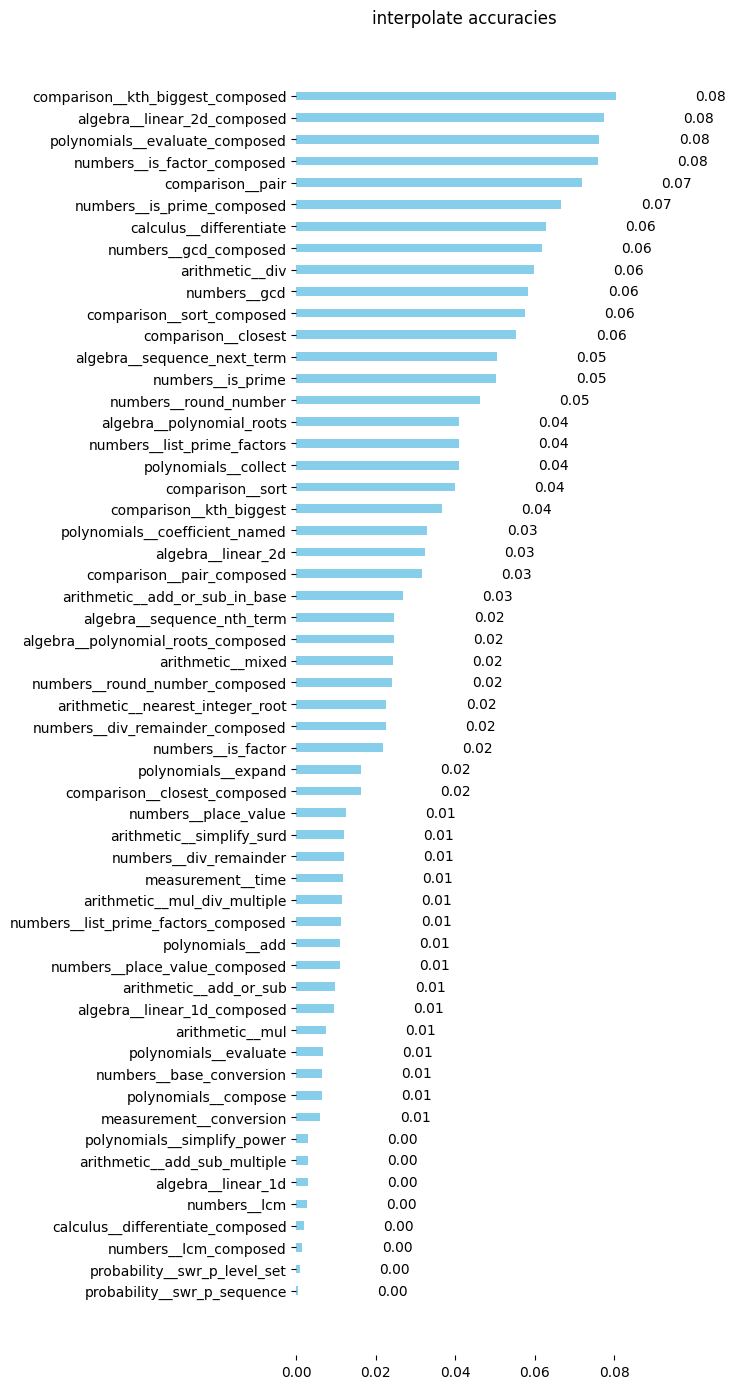

In [ ]:
print_results("interpolate", interpolate_accuracies["accuracies"])

In [ ]:
import numpy as np

checkpoint_path = '/content/checkpoints/best_model.ckpt'
checkpoint = torch.load(checkpoint_path, map_location='cuda')

# Initialize the model and the pl wrapper
model = TPTransformer(len(vocab))
lit_model = LitModel(model).to('cuda')
lit_model.load_state_dict(checkpoint['state_dict'])

question_final = 'what is  1 + 1?'
question_a = 'Let a = -4 - -5. Let w be 9/(-42) + 1/2. Is w at least as big as a?'
question_b = 'Let g be ((-4)/(-56))/(2/(-8)). Is -0.7 >= g?'
question_c = 'Let v(g) = g**3 + 8*g**2 + 11*g - 10. Let x be v(-6). Which is smaller: -3 or x?'
question_d = 'Let c = 6 + -9. Let b = -2 + 3. Is b less than or equal to c?'
question_e = 'Which is bigger: 1265 or 1264?'
question_f = 'Is 8156 > 8158?'
question_g = 'Which is bigger: -1/3087 or -1?'
question_w = 'Solve -4*o + 2*p + 5 = 23, -2*o = -4*p + 18 for o.'
question_p = 'is 13 prime?'
questions = [question_final, question_a, question_b, question_c, question_d, question_e, question_f, question_g, question_w, question_p]
#convert to digits

answer = [vocab['$']]
lit_model.eval()
for question in questions:
    ids = torch.tensor([vocab['$']] + [vocab[c.lower()] for c in question] + [vocab['§']] + [vocab['˽']] * (162 - len(question)) ).to('cuda')
    ids = ids.unsqueeze(0)

    print(question)
    outputs = lit_model.model.predict(ids)#.squeeze(0)

    answer = lit_model.decode_sentences(outputs)[0].replace('˽', '')
    #answer = ''.join([vocab.get_itos()[i] for i in outputs])
    print(answer)


what is  1 + 1?
$2§
Let a = -4 - -5. Let w be 9/(-42) + 1/2. Is w at least as big as a?
$false§
Let g be ((-4)/(-56))/(2/(-8)). Is -0.7 >= g?
$false§
Let v(g) = g**3 + 8*g**2 + 11*g - 10. Let x be v(-6). Which is smaller: -3 or x?
$-3§
Let c = 6 + -9. Let b = -2 + 3. Is b less than or equal to c?
$true§
Which is bigger: 1265 or 1264?
$1265§
Is 8156 > 8158?
$false§
Which is bigger: -1/3087 or -1?
$-1/3087§
Solve -4*o + 2*p + 5 = 23, -2*o = -4*p + 18 for o.
$-5§
is 13 prime?
$false§
